# EGM algorithm for simpel firm problem with 1 endogenous state

## Setup - import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from SSJ_ext.het_block import het
import EGM_utils # helper functions for solving DP problem 
import SSJ_ext.utils as utils 
import SSJ_ext.jacobian as jac # to calculate jacobians for IRFs

# EGM backstep 

#### The function Firm_prop_simple does one backstep given (marginal) continuation values. Iterating on this function until convergence yields the fixed point of the problem 

In [10]:
@het(exogenous='Pi_p', policy=['n'], backward=['mCont_val'])
def Firm_prop_simple(mCont_val_p, Pi_p, n_grid, z_grid, alpha, theta, p, delta, gamma, pR, pN, interest):
    """Single backward iteration step using endogenous gridpoint method"""
    z = z_grid
    beta = 1/(1+interest)
    
    dfgamma1 = EGM_utils.get_gamma_derive(n_grid[:, np.newaxis], n_grid[np.newaxis, :], gamma)[1] 
    
    # take expectation over future marginal continuation value
    E_mCont_val = beta * EGM_utils.matrix_times_first_dim(Pi_p, mCont_val_p) 
    # find materiales given todays labor input (n_grid)
    r = EGM_utils.inv_R_demand(pR, theta, alpha, z[:, np.newaxis], n_grid[np.newaxis, :], p)
    # marginal product of labor 
    MPN = p * alpha * z[:, np.newaxis] * n_grid[np.newaxis, :]**(alpha-1) * r**theta 

    # solve for todays labor input using dynamic FOC using interpolation (i.e. interpolate such that rhs = lhs)
    rhs = MPN + E_mCont_val
    lhs = pN + dfgamma1

    i, pi = EGM_utils.lhs_equals_rhs_interpolate(rhs, lhs)
    n = utils.apply_coord(i, pi, n_grid)  
    r = EGM_utils.inv_R_demand(pR, theta, alpha, z[:, np.newaxis], n, p)

    y = z[:, np.newaxis] * n**alpha * r**theta 
    dfgamma2 = EGM_utils.get_gamma_derive(n, n_grid[np.newaxis, :], gamma)[2]
        
    # calculate marginal continuation value for further backwards iteration 
    mCont_val = pN * (1-delta) - dfgamma2
    
    return n, r, y, mCont_val

## Choose parameters and solve steady state

In [11]:
# parameters - relatively randomly chosen 
pars = {'alpha' : 0.3, 'theta' : 0.4, 'p' : 1, 'pN' : 1.2, 'delta' : 0.1, 'gamma' : 2, 'interest' : 0.03, 'pR' : 0.6}

# grid for labor  
n_grid = 0.5   + utils.agrid(amax=4, n=300)

# grid for idiosynchratic productivty
# no heterogeighty for now to compare with jac solution (see below) so set variance to 0 (1e-08)
rho, sigma, NZ = 0.9, 1e-08, 2 # persistance, std and number of points in shock process for z 

# starting values for backwards iteration 
mCont_val = np.zeros([NZ, len(n_grid)])
mCont_val += pars['pN'] * (1-pars['delta'])  

pars.update({'n_grid':n_grid, 'rho':rho, 'sigma':sigma, 'NZ':NZ,'mCont_val':mCont_val})

# iterate until steady state is reached 
Firm_prop_simple_het = Firm_prop_simple.attach_hetinput(EGM_utils.HET_add_ons)
ss = Firm_prop_simple_het.ss(**pars, accelerated_it = False, noisy=True)

print('SS value of labor and materials:', ss['N'],'and', ss['R'])

Iteration: 0
Converged after : 61 iterations
SS value of labor and materials: 2.2849963602778467 and 0.7690539010457289


## IRF to announced price shock 

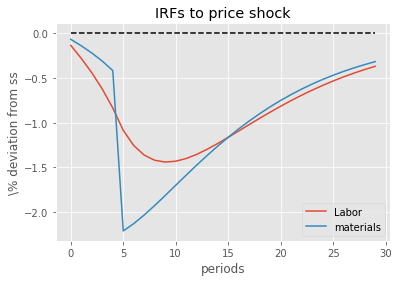

In [12]:
Time = 300     
# ttt = np.arange(0,Time)
ann = 5
dp = np.zeros(Time)
dp[ann:] = - 0.01  * 0.9**(np.arange(Time-ann))
J      = Firm_prop_simple_het.jac(ss, Time, ['p'])  # get jacobian    

dN = J['N']['p'] @ dp * 100 / ss['N']
dR = J['R']['p'] @ dp * 100 / ss['R']

plt.plot(dN[:30], label='Labor')
plt.plot(dR[:30], label='materials')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('IRFs to price shock')
plt.ylabel(r'\% deviation from ss')
plt.xlabel(r'periods')
plt.legend()
plt.show() 

## Comparison

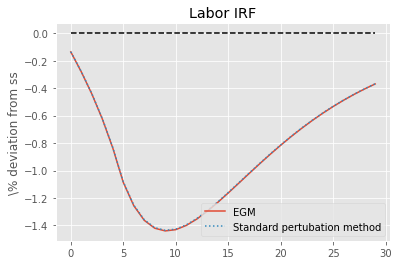

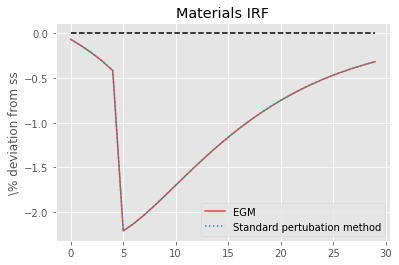

In [13]:
# Since there is no heterogeneity in the above model we can compare the solution to the one obtained 
# from a simple model solved using either standard pertubation methods (first-order approx. around steady-state as in dynare etc.)
# or compute full non-linear solution using a newton-solver.
# The solution using EGM and either of these methods should be identical (if grids for EGM are dense enough)

from solved_block import solved

# define block with equations
@solved(unknowns=['N', 'R'], targets=['N_res', 'R_res'])
def firm_block(alpha, theta, interest, p, pN, pR, Z, gamma, N, R, delta):
    beta = 1 /(1+interest)
    R_res = theta*p*Z*N**(alpha)*R**(theta-1) - pR 
    dfgamma1 = gamma * (N/N(-1)-1) 
    dfgamma2 = gamma /2 * (N(+1)/N-1)**2 - gamma * (N(+1)/N-1) * N(+1)/N
    N_res = alpha*p*Z*N**(alpha-1)*R**theta + beta*(1-delta)*pN(+1) - beta*dfgamma2 - (pN + dfgamma1)
    Y = Z * N**alpha * R**theta
    return N_res, R_res, Y

ss.update({'Z':1})
J_simple =   firm_block.jac(ss, Time, ['p'])     

dN_simple = J_simple['N']['p'] @ dp * 100 / ss['N']
dR_simple   = J_simple['R']['p'] @ dp * 100 / ss['R']

plt.plot(dN[:30], label='EGM')
plt.plot(dN_simple[:30], ':', label='Standard pertubation method')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('Labor IRF')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 

plt.plot(dR[:30], label='EGM')
plt.plot(dR_simple[:30], ':', label='Standard pertubation method')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('Materials IRF')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 

### They coincide! hurray!